In [36]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
%matplotlib inline 
import seaborn as sns
import sklearn
from IPython.display import Image
from IPython.display import Markdown, display

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

# from scipy.stats import uniform
# from sklearn import ensemble
import warnings
pd.set_option('display.max_columns', None)
import pickle

<a class="anchor" id="i1overfit"></a>
### Table of Contents

* [Support Functions](#SupportFunctions)
    * [Hyperparameter Grid](#paramgird)
* [Creating Models](#CreatingModels)
    * [Iteration1 - Model1](#basemodel)
        * [Results - Overfit Check](#i1overfit)
        * [Results - Scores & Observation](#i1scores)
    * [Iteration2 - SMOTE, Feature Selection](#I2Model)
         * [Feature Selection & SMOTE](#featureselection)
         * [Model2](#model2)
         * [Results - Overfit Check](#i2overfit)
         * [Results - Scores & Observation](#i2scores)
    * [Iteration3 - Hyper-Tuning RandForest](#I3Model)
        * [Results - Overfit Check](#i3overfit)
        * [Results - Scores & Observation](#i3scores)
* [Final Results & Observations](#finalObs)
    * [Feature Importance](#featureImportance)
* [X Factor - Reviewing Thresholds](#Xfactor)
* [Conclusions - Summary Observations](#summaryObs)    

In [37]:
# Load Data From Pickel
with open('./data/df_wD.pickle', 'rb') as file:
    df_wD = pickle.load(file)

with open('./data/df_wD_all.pickle', 'rb') as file:
    df_wD_all = pickle.load(file)
df_CleanCol_Names = pd.read_excel("./data/CleanColumnNames.xlsx")

# Support Functions <a class="anchor" id="SupportFunctions"></a>

In [38]:
def get_Scaled_TrainTestSplit_W_orWO_Smote(X, y, SmoteYorN):
    '''Returns Scaled, train-test split data, and either SMOTE or No SMOTE, takes in X, y and "Y/N", returns data'''
    
    # Split data between train and test
    X_train_wo_Scaling_Or_Smote, X_test_wo_Scaling, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    #scale using min max
    df_X_train_sc, df_X_test_sc = scaleData(X_train_wo_Scaling_Or_Smote,X_test_wo_Scaling)
    
    if SmoteYorN =="Y":
        smote = SMOTE(random_state=41, sampling_strategy=1)
        X_train, y_train = smote.fit_sample(df_X_train_sc, y_train) 
        print(f'SMOTED\n: {y_train.value_counts()}')
    elif SmoteYorN =="N":
        X_train = df_X_train_sc
        y_train = y_train
        print(f'Not SMOTED\n: {y_train.value_counts()}')
    
    return  X_train, y_train, df_X_test_sc, y_test

def scaleData(X_train_wo_Scaling_Or_Smote,X_test_wo_Scaling):
    '''Scaler, takes in X_train and X_test, returns scaled data'''
    scaler = MinMaxScaler(feature_range = (0,1))

    #Fit
    scaler.fit(X_train_wo_Scaling_Or_Smote)

    #Transform
    X_train_sc = scaler.transform(X_train_wo_Scaling_Or_Smote)
    X_test_sc = scaler.transform(X_test_wo_Scaling)
    #convert back to dataframe
    df_X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_wo_Scaling_Or_Smote.columns)
    df_X_test_sc = pd.DataFrame(X_test_sc, columns=X_train_wo_Scaling_Or_Smote.columns)
    return df_X_train_sc, df_X_test_sc


# -----------------------Classification Metrics Functions
    
def createAUCReport(model, X_, y_, RsgName = None):
    '''Creates and plots ROC, called by createConfusionMatrix2() function'''
    print(RsgName)
    y_scores = model.predict_proba(X_)
    y_score =  y_scores[:, 1]
    fpr, tpr, thresholds = roc_curve(y_, y_score)
    AUC = auc(fpr, tpr)
    rndAuC = round(AUC,2)
    return rndAuC ,fpr, tpr, thresholds


def createROCCurve(result_table):
    '''Creates and plots multiple ROC, takes in a df of classifiers along with results'''
    fig = plt.figure(figsize=(8,6))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{},-{}:, AUC={:.3f},R={:.3f}".format(result_table.loc[i]['clf_name'],
                                                                  result_table.loc[i]['dataset'], result_table.loc[i]['auc'],
                                                                  result_table.loc[i]['recall'])
                )

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Flase Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':10}, loc='lower right')

    plt.show()

def createClassificationReport(y_test, y_hat_test, name):
    '''Creates classification report, takes in actual y and predicted y along with name or classifier, 
    returns a df of results'''
    report = classification_report(y_test, y_hat_test, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df["SMOTE"] = name
    return df

        
def createConfusionMatrix2(model, X_train, y_train, y_hat_train, X_test,y_test, y_hat_test):
    '''Creates confusion matrix takes in results from classifer along with the actual classifer, 
    plots 2 matrix, one with acutal #'s other normalized'''
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    model_name = type(model).__name__
    
    #Plot Training Matrix
    plot_confusion_matrix(model, X_train, y_train, ax=axes[0,0], cmap='Blues', display_labels=["Loyal","Churn"],
                          colorbar = False)
    cm_train = confusion_matrix(y_train, y_hat_train)
    #normalized
    plot_confusion_matrix(model, X_train, y_train, ax=axes[1,0], 
                          cmap='Blues', display_labels=["Loyal","Churn"], normalize='true',colorbar = False)
    
    
    #Plot Training Matrix
    plot_confusion_matrix(model, X_test, y_test, ax=axes[0,1], cmap='Blues', display_labels=["Loyal","Churn"],
                          colorbar = False)
    cm_test = confusion_matrix(y_test, y_hat_test)
    #normalized
    plot_confusion_matrix(model, X_test, y_test, ax=axes[1,1], 
                          cmap='Blues', display_labels=["Loyal","Churn"],normalize='true',colorbar = False)
    
    axes[0,0].title.set_text(f'{model_name} Train')
    axes[0,1].title.set_text(f'{model_name} Test')
    axes[1,0].title.set_text(f'{model_name} Train')
    axes[1,1].title.set_text(f'{model_name} Test')

    
    plt.tight_layout()
    plt.show()
    
def createvisuals(df_classifiers,X_train,y_train,X_test,y_test, df_classifier_scores):
    '''Creates confusion matrix takes in results from classifer along with the actual classifer, 
    plots all results from multiple classifiers and plots'''
 
    df_Reports = pd.DataFrame(columns=['precision', 'recall', 'f1-score', 'support', 'SMOTE', 'C'])

    df_DataForPloting_ROC = pd.DataFrame(columns=['clf_name','modifiers' ,'dataset','fpr','tpr','auc',
                                                  "SMOTE", 'recall', 'precision','df'])

    for i in df_classifiers.index:
    
        clf = df_classifiers.loc[i]['clf']
        clf_name = df_classifiers.loc[i]['clf_name']
        
        print(clf_name)

        y_hat_train = clf.predict(X_train)
        y_hat_test = clf.predict(X_test)

        #Create Dataframe of results________________________________
        yhat_test_probs = clf.predict_proba(X_test)

        preds = clf.predict_proba(X_test)
        preds = pd.DataFrame(preds)
        preds.columns = ["Loyal_Prob", "Churn_Prob"]

        y_test.reset_index(drop=True, inplace=True)
        preds['churn'] = y_test
        preds['churn_Pred'] = y_hat_test
        preds['wrong'] = preds.apply(lambda x: 1 if x.churn - x.churn_Pred !=0 else 0, axis=1)
        preds['Correct?'] = preds['churn'] == preds['churn_Pred']

        preds.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)

        df_results = pd.concat([preds,X_test],axis=1)
        df_results
    #     ______________________________

        #Create Confusion Matrix
        createConfusionMatrix2(clf, X_train, y_train, y_hat_train, X_test,y_test, y_hat_test)

        #Get ROC Datapoints, Store In Dataframe, One Rows for each classifier - Train and Test

        # Train AUC #'s
        Auc_Train, fpr_Train, tpr_Train, thresholds_Train = createAUCReport(clf, X_train, y_train,clf_name)

        # Train recall & precision #'s
        recall_train = round(recall_score(y_train, y_hat_train),2)
        precision_train = round(precision_score(y_train, y_hat_train),2)


        #insert training classifier#'s' into dataframe
        df_DataForPloting_ROC = df_DataForPloting_ROC.append({'fpr':fpr_Train, 'tpr':tpr_Train, 'auc':Auc_Train, 
                                                              'dataset':"Train",'clf_name':clf_name,"SMOTE":0, 
                                                              'recall':recall_train,"precision":precision_train,
                                                             'modifiers':"None"}, ignore_index=True)

        #Testing AUC #'s
        Auc_Test, fpr_Test, tpr_Test, thresholds_Test = createAUCReport(clf, X_test, y_test, clf_name)

        #Test recall & precision #'s
        recall_test = round(recall_score(y_test, y_hat_test),2)
        precision_test = round(precision_score(y_test, y_hat_test),2)


        #Insert Testing classifier#'s' into dataframe
        df_DataForPloting_ROC = df_DataForPloting_ROC.append({'fpr':fpr_Test, 'tpr':tpr_Test, 'auc':Auc_Test, 
                                                              'dataset':"Test", 'clf_name':clf_name,"SMOTE":0, 
                                                              'recall':recall_test,"precision":precision_test,
                                                             'modifiers':"None",'df':df_results}, ignore_index=True)

        df_DataForPloting_ROC_Current = df_DataForPloting_ROC[df_DataForPloting_ROC["clf_name"]==clf_name]
        createROCCurve(df_DataForPloting_ROC_Current)

        #Create Classification Detail Report
        report = createClassificationReport(y_test, y_hat_test,"test")
        report["C"] = i
        df_Reports = df_Reports.append(report)
       
        display(Markdown('---'))

    df_DataForPloting_ROC.rename(columns={"clf_name": "clf_name1"}, inplace = True)

    # combine raw data with results
    df_All_classifierData = pd.concat([df_DataForPloting_ROC, df_classifier_scores], axis=1)

    # get just the test data
    df_All_classifierData_Test = df_All_classifierData[df_All_classifierData.dataset =="Test"]

    #Get just the "Scores for test data"
    df_All_classifierScores_Test = df_All_classifierData_Test.drop(
        columns=['fpr', 'tpr', 'SMOTE', 'set', 'clf_name1'])
    #reorder Columns for the"Scores dataframe
    df_All_classifierScores_Test = df_All_classifierScores_Test[['clf_name', 'dataset', 'auc', 
                                                                       'recall', 'precision','mscore','modifiers']]
    return df_All_classifierData , df_All_classifierData_Test, df_All_classifierScores_Test

def createDfsOFClassifiers(dictOfHyperParams):
    '''Creates a dict of classifier params and returns a data frame containing classifiers ready to .fit()/ .predict()'''
    warnings.filterwarnings("ignore")
    classifiers = []


    pipe_knn = Pipeline([('clf',KNeighborsClassifier())])
    pipe_dt = Pipeline([('clf',DecisionTreeClassifier())])
    pipe_rf = Pipeline([('clf',RandomForestClassifier(random_state=0))])
    jobs = -1
    cv = 10

    Rgs_knn = GridSearchCV(estimator=pipe_knn,param_grid=dictOfHyperParams["hyp_params_knn"],scoring='recall',cv=cv,n_jobs=jobs)
    classifiers.append(("knn",Rgs_knn))

    Rgs_dt = GridSearchCV(estimator=pipe_dt,param_grid=dictOfHyperParams["hyp_params_dt"],scoring='recall',cv=cv, n_jobs=jobs)
    classifiers.append(("dt",Rgs_dt))

    Rgs_rf = GridSearchCV(estimator=pipe_rf,param_grid=dictOfHyperParams["hyp_params_rf"],scoring='recall',cv=cv, n_jobs=jobs)
    classifiers.append(("rf",Rgs_rf))
    return classifiers


def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    """
    # playing with thresholds to reduce recall
    #https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    
    return [1 if y >= t else 0 for y in y_scores]

### Hyperparameter Grid <a class="anchor" id="paramgird"></a>

In [39]:
def paramScenarios(parmsNumber,dataNumber):
    dictOfHyperParams ={}
    '''Contains all the hyper params and columns to be used for each classifer by iteration for this project'''
    
# Initial iteration no tuning, select basic parameters for start
    if parmsNumber ==1:
        
        # Knn Params For Gridsearch
        hyp_params_knn = [{
            'clf__n_neighbors': [3]}]
        dictOfHyperParams.update({"hyp_params_knn":hyp_params_knn})
        
        # DT Params For Gridsearch            
        hyp_params_dt = [{
            'clf__max_depth': [5],
            'clf__max_features': ["sqrt"],
            'clf__criterion': ['gini'],
            'clf__min_samples_split': [10]}]
        dictOfHyperParams.update( {"hyp_params_dt":hyp_params_dt})
        
        # RF Params For Gridsearch    
        hyp_params_rf = [{'clf__criterion': ['entropy'],
          'clf__max_depth': [5],
          'clf__n_estimators': [150],
          'clf__min_samples_leaf':[50],
         'clf__max_features': ["sqrt"],
         'clf__random_state':[0]}]
        dictOfHyperParams.update( {"hyp_params_rf":hyp_params_rf})
        
# Still no changes in parameters, as changing SMOTE and features
    if parmsNumber ==2:
        
        # Knn Params For Gridsearch
        hyp_params_knn = [{
            'clf__n_neighbors': [3]}]
        dictOfHyperParams.update({"hyp_params_knn":hyp_params_knn})
        
        # DT Params For Gridsearch            
        hyp_params_dt = [{
            'clf__max_depth': [5],
            'clf__max_features': ["sqrt"],
            'clf__criterion': ['gini'],
            'clf__min_samples_split': [10]}]
        dictOfHyperParams.update( {"hyp_params_dt":hyp_params_dt})
        
        # RF Params For Gridsearch    
        hyp_params_rf = [{'clf__criterion': ['entropy'],
          'clf__max_depth': [5],
          'clf__n_estimators': [150],
          'clf__min_samples_leaf':[50],
         'clf__max_features': ["sqrt"],
         'clf__random_state':[0]}]
        dictOfHyperParams.update( {"hyp_params_rf":hyp_params_rf})
        
# Final tuning with SMOTE      
    if parmsNumber ==3:
        # Knn Params For Gridsearch
        hyp_params_knn = [{
            'clf__metric': ['euclidean', 'manhattan'],
            'clf__n_neighbors': list(range(1,15)),
            'clf__weights': ['uniform', 'distance'],
            'clf__p': [1, 2, 10]}]
        dictOfHyperParams.update({"hyp_params_knn":hyp_params_knn})

        # DT Params For Gridsearch            
        hyp_params_dt = [{
            'clf__max_depth': [25, 50, 75],
            'clf__max_features': ["sqrt", "auto"],
            'clf__criterion': ['gini', 'entropy'],
            'clf__min_samples_split': [6, 10, 14]}]
        dictOfHyperParams.update({"hyp_params_dt":hyp_params_dt})

        # Rf Params For Gridsearch
        hyp_params_rf = [{
            'clf__criterion': ['gini'],
            'clf__max_depth': [1],
            'clf__n_estimators': [700],
            'clf__min_samples_split': [2, 3, 5],
            'clf__min_samples_leaf':[600],
            'clf__max_features': [.2],
            'clf__oob_score':[True],
            'clf__bootstrap': [True],
            'clf__random_state':[0]}]

        dictOfHyperParams.update({"hyp_params_rf":hyp_params_rf})
        
        
 #___________________Setting Data Parameters       
    
        
    if dataNumber == 1:
        #All data to start with
        colsToInclude = X.columns
        
    if dataNumber == 2:
        colsToInclude = ['tenure','PyM_Chk_E','IsrvcType_FO','Cntrct_M2M','ChrgTtls','ChrgMnthly','tenureSeg_>= 9M',
         'tenureSeg_>= 29M','TS_Y','StrTV_Y','StrMvs_Y','Sex_M','PlB_Y','PhSrv_Y','OlSec_Y','MLns_Y',
         'IsrvcType_No','Cntrct_2Yr','ChrgTtlsSeg_>= $1397M','65p_Y','tenureSeg_>= 55M','servCnt','ServCntSeg_>= 4Srvc',
                         'ServCntSeg_>= 2Srvc','PyM_Chk_M']
        
        
    if dataNumber == 3:
        colsToInclude = ['tenure','PyM_Chk_E','IsrvcType_FO','Cntrct_M2M','ChrgTtls','ChrgMnthly','tenureSeg_>= 9M',
                         'tenureSeg_>= 29M','servCnt','TS_Y','StrTV_Y','StrMvs_Y','Sex_M','PlB_Y','PhSrv_Y',
                         'OlSec_Y','MLns_Y','Isrvc_Y','IsrvcType_No','Cntrct_2Yr','ChrgTtlsSeg_>= $1397M','65p_Y',
                         'tenureSeg_>= 55M','ServCntSeg_>= 4Srvc','ServCntSeg_>= 2Srvc']
    return dictOfHyperParams, colsToInclude


# Create Models <a class="anchor" id="CreatingModels"></a>

## Iteration 1 - Base Models

---

Not SMOTED
: 0    4125
1    1500
Name: Churn, dtype: int64


---

knn


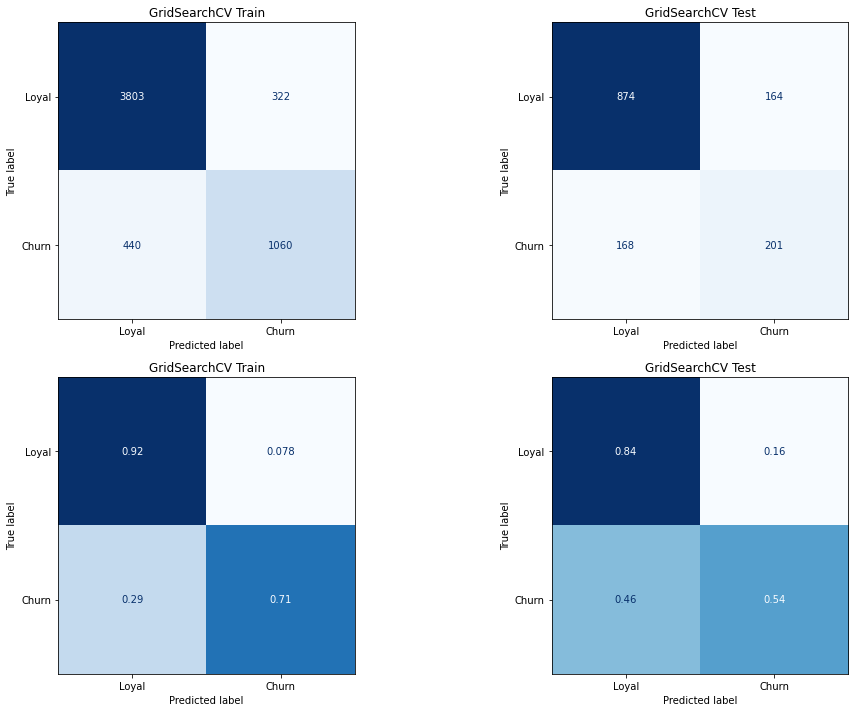

knn
knn


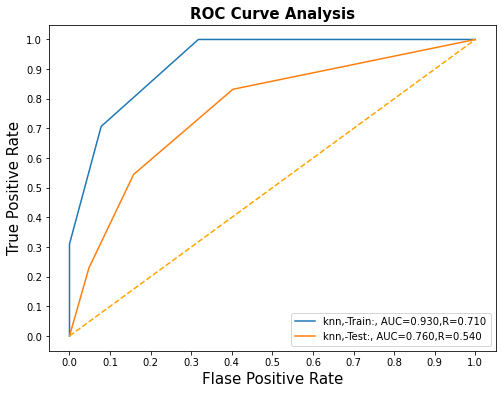

---

dt


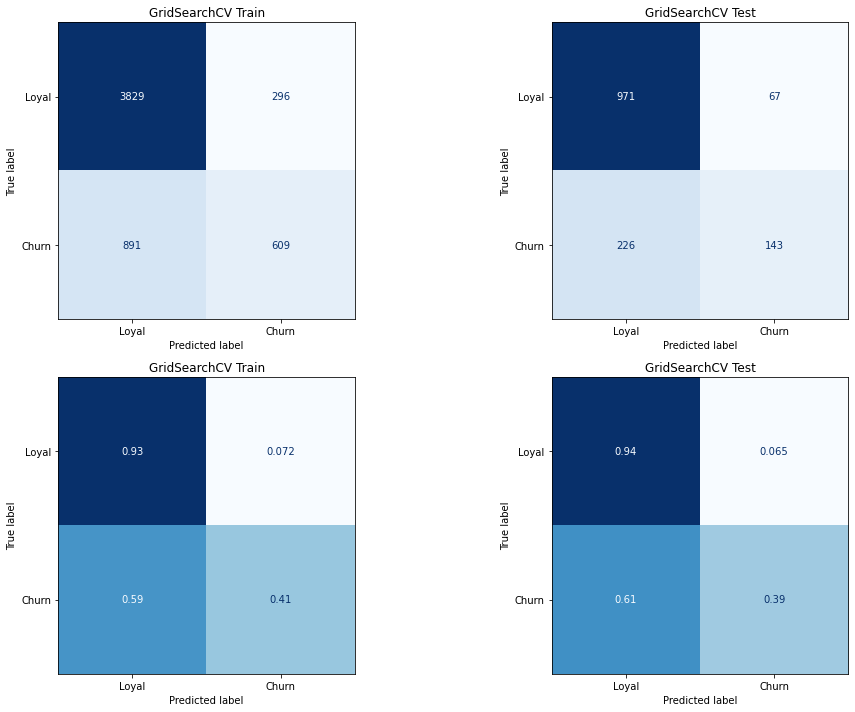

dt
dt


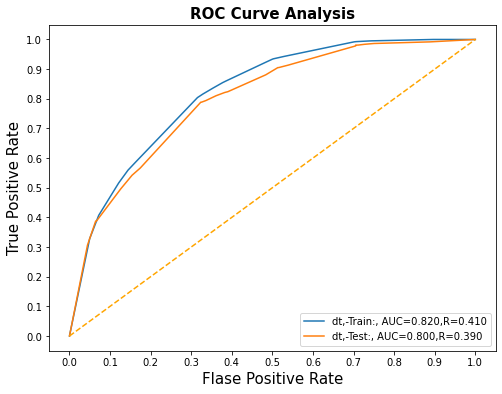

---

rf


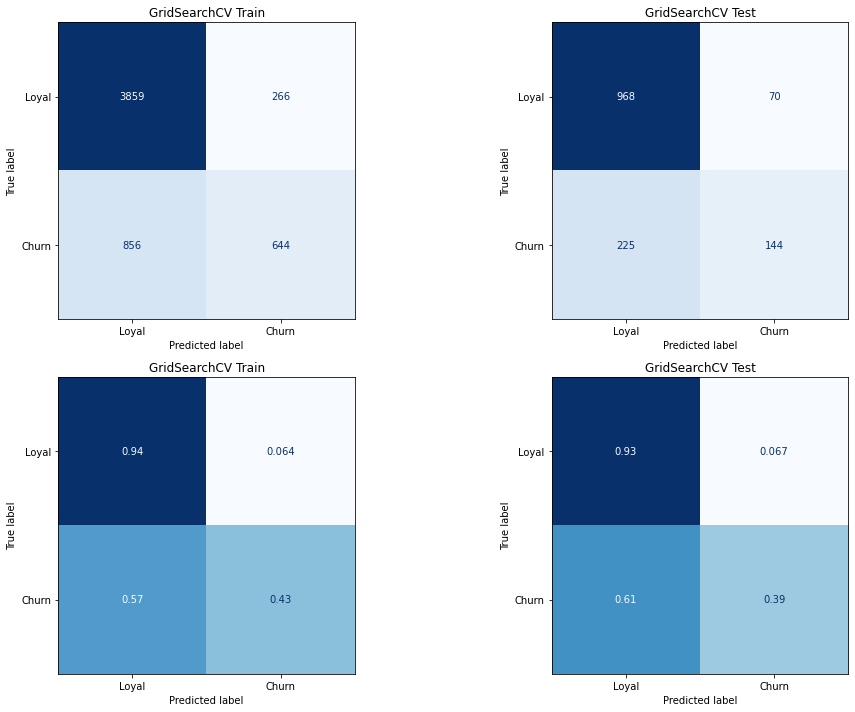

rf
rf


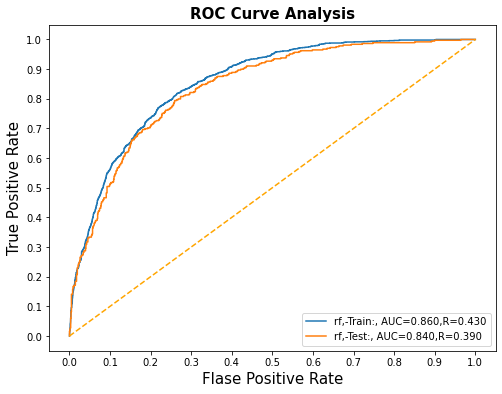

---

In [40]:
# Get Data
X = df_wD.drop(columns=["Churn"])
y = df_wD["Churn"]


# paramScenarios(parmsNumber,dataNumber)
dictOfHyperParams, colsToInclude = paramScenarios(1,1)
classifiers = createDfsOFClassifiers(dictOfHyperParams)

#Create Line Between Printouts
display(Markdown('---'))

X1 = X[colsToInclude]

X_train, y_train, X_test, y_test = get_Scaled_TrainTestSplit_W_orWO_Smote(X1,y,"N")
display(Markdown('---'))

warnings.filterwarnings("ignore")
df_classifiers_I1 = pd.DataFrame(columns=['clf_name','clf'])
df_classifier_scores = pd.DataFrame(columns=['clf_name','set','mscore'])

for clf_name, classifier in classifiers:
    pipe = classifier
    pipe.fit(X_train, y_train)
    modelscore_Train = round(pipe.score(X_train, y_train),2)
    modelscore_Test = round(pipe.score(X_test, y_test),2)
    
    # Store classifiers and scoring into a dataframe for future use
    df_classifiers_I1 = df_classifiers_I1.append({'clf_name':clf_name, 'clf':classifier,"X_test":X_test,"y_test":y_test}, ignore_index=True)
    df_classifier_scores = df_classifier_scores.append({'clf_name':clf_name, "set":"Train","mscore":modelscore_Train}, ignore_index=True)
    df_classifier_scores = df_classifier_scores.append({'clf_name':clf_name, "set":"Test","mscore":modelscore_Test}, ignore_index=True)

df_All_classifierData_I1 , df_All_classifierData_Test_I1, df_All_classifierScores_Test_I1 = createvisuals(df_classifiers_I1,X_train,y_train,X_test,y_test, df_classifier_scores)

### Create/ Fit Classifiers using Pipeline/ Create Visuals <a class="anchor" id="basemodel"></a>

### Review Train vs. Test Accuracy Scores For Overfitting <a class="anchor" id="i1overfit"></a

In [41]:
df_All_classifierData_I1["Rnd"] = 1
df_All_classifierData_I1[["Rnd","clf_name","set","mscore","recall","precision"]]

,Rnd,clf_name,set,mscore,recall,precision
0,1,knn,Train,0.71,0.71,0.77
1,1,knn,Test,0.54,0.54,0.55
2,1,dt,Train,0.41,0.41,0.67
3,1,dt,Test,0.39,0.39,0.68
4,1,rf,Train,0.43,0.43,0.71
5,1,rf,Test,0.39,0.39,0.67


### Veiw Test results only <a class="anchor" id="i1scores"></a>

  clf_name dataset   auc  recall  precision  mscore modifiers
1      knn    Test  0.76    0.54       0.55    0.54      None
3       dt    Test  0.80    0.39       0.68    0.39      None
5       rf    Test  0.84    0.39       0.67    0.39      None



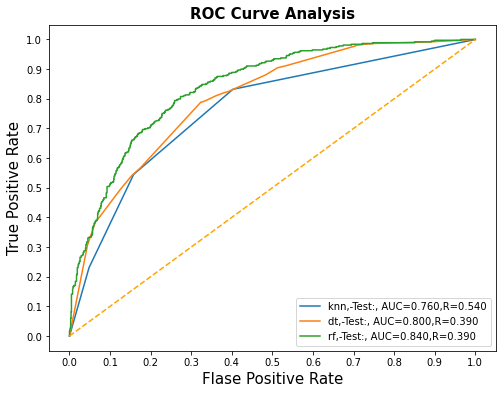

In [42]:
#sort both dataframes by recall for presentation
# View Scores
df_All_classifierScores_Test_I1 = df_All_classifierScores_Test_I1.sort_values(by="recall", ascending=False)
print(df_All_classifierScores_Test_I1)

#View ROC
df_All_classifierData_Test_I1 = df_All_classifierData_Test_I1.sort_values(by="recall", ascending=False)
df_All_classifierData_Test_I1 = df_All_classifierData_Test_I1.reset_index(drop=True)
print()
createROCCurve(df_All_classifierData_Test_I1)

OBSERVATIONS:  
* `Inital Models Performing poorly (still without tuning or SMOTE), Recall Scores Range from 50-67`
* `Bigger problem is overfitting for all models, big gap between train and test mscores`

### Save all Iteration 1 Data

In [43]:
with open('./data/df_classifiers1.pickle', 'wb') as f:
    pickle.dump(df_classifiers_I1, f)

with open('./data/df_All_classifierData_I1.pickle', 'wb') as f:
    pickle.dump(df_All_classifierData_I1, f)
    
with open('./data/df_All_classifierScores_Test_I1.pickle', 'wb') as f:
    pickle.dump(df_All_classifierScores_Test_I1, f)

## Iteration 2 - SMOTE & Feature Selection<a class="anchor" id="I2Model"></a>

### Feature Selection using Iteration 1 Models (Feature_importance) <a class="anchor" id="featureselection"></a>

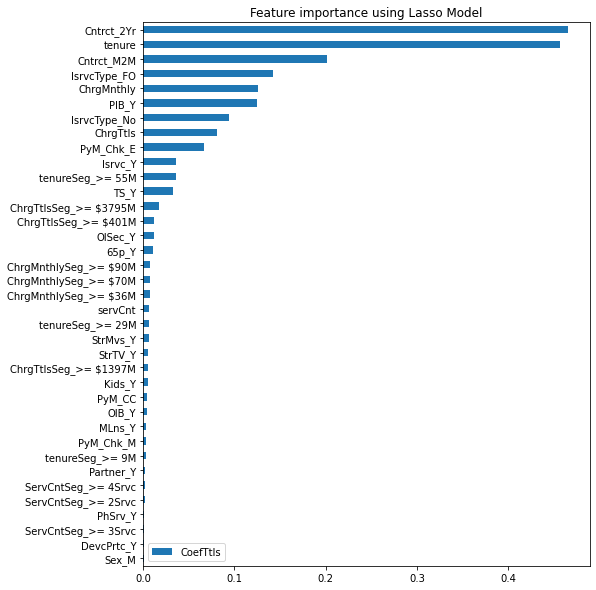

In [44]:
# Get get and store important features from classifiers where possible
dictOfDfs_Importantfeatures = {}
for index, row in df_classifiers_I1.iterrows():
    clf = row['clf']
    xtest = row['X_test']
    clf_name = row['clf_name']
    if clf_name != "knn":
        df_feature_importances = pd.concat([pd.DataFrame(xtest.columns, columns = ["features"]),
                                            pd.DataFrame(np.transpose(clf.best_estimator_.named_steps['clf'].feature_importances_), columns = ["coef"])],axis = 1)
        df_feature_importances["coef"] = round(df_feature_importances["coef"],3)
        dfname = "df_{}".format(clf_name)
        dictOfDfs_Importantfeatures[dfname] = df_feature_importances
        
# Load Important features into dict then into dataframe
df_dt = dictOfDfs_Importantfeatures.get("df_dt")
df_dt.rename(columns={"coef": "dt"},inplace=True)
df_rf = dictOfDfs_Importantfeatures.get("df_rf")
df_rf.rename(columns={"coef": "rf"}, inplace=True)
df_All_ImportanceScores_I1 = df_dt.merge(df_rf, on="features")

# Get ranking of each coef from relevant models to aid in selecting "Top" features
df_All_ImportanceScores_I1['dt_rk'] = df_All_ImportanceScores_I1['dt'].rank(ascending=False)
df_All_ImportanceScores_I1['rf_rk'] = df_All_ImportanceScores_I1['rf'].rank(ascending=False)
df_All_ImportanceScores_I1['rk_avg'] = round(df_All_ImportanceScores_I1[['dt_rk', 'rf_rk']].mean(axis=1),2)


#select top x features
df_All_ImportanceScores_I1 = df_All_ImportanceScores_I1.sort_values(by="rk_avg", ascending=True)
df_All_ImportanceScores_I1["CoefTtls"] = df_All_ImportanceScores_I1["dt"]+df_All_ImportanceScores_I1["rf"]
df_All_ImportanceScores_I1 = df_All_ImportanceScores_I1.reset_index(drop=True)
# df_All_ImportanceScores_I1

imp_coef = df_All_ImportanceScores_I1[['features','CoefTtls']]
imp_coef = imp_coef.sort_values(by="CoefTtls")
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
ax = imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

# ax = freq_series.plot(kind='bar')
# ax.set_title('Amount Frequency')
# ax.set_xlabel('Amount ($)')
# ax.set_ylabel('Frequency')
ax.set_yticklabels(imp_coef['features']);
plt.show();

In [45]:
#Veiw Scores in df
df_All_ImportanceScores_I1

,features,dt,rf,dt_rk,rf_rk,rk_avg,CoefTtls
0,tenure,0.297,0.160,2.0,2.0,2.00,0.457
1,Cntrct_2Yr,0.353,0.113,1.0,3.0,2.00,0.466
2,Cntrct_M2M,0.010,0.192,8.0,1.0,4.50,0.202
3,IsrvcType_FO,0.056,0.086,5.0,4.0,4.50,0.142
4,ChrgMnthly,0.069,0.057,4.0,7.0,5.50,0.126
5,PlB_Y,0.107,0.018,3.0,11.0,7.00,0.125
6,IsrvcType_No,0.055,0.039,6.0,8.0,7.00,0.094
7,ChrgTtls,0.005,0.076,10.5,5.0,7.75,0.081
8,PyM_Chk_E,0.001,0.066,16.0,6.0,11.00,0.067
9,TS_Y,0.026,0.007,7.0,16.0,11.50,0.033


In [46]:
#Place Top 15 importnat scores into a list 
ls_Top_features_I1 = df_All_ImportanceScores_I1['features'][0:15].tolist()
ls_Top_features_I1

['tenure',
 'Cntrct_2Yr',
 'Cntrct_M2M',
 'IsrvcType_FO',
 'ChrgMnthly',
 'PlB_Y',
 'IsrvcType_No',
 'ChrgTtls',
 'PyM_Chk_E',
 'TS_Y',
 '65p_Y',
 'ChrgTtlsSeg_>= $401M',
 'Isrvc_Y',
 'tenureSeg_>= 55M',
 'servCnt']

### Feature Selection - Sk Learn

In [47]:
X = df_wD.drop(columns=["Churn"])
y = df_wD["Churn"]

#### Chi2

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi_selector = SelectKBest(chi2)
chi_selector.fit(X, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

10 selected features


#### RFE

In [49]:
warnings.filterwarnings("ignore")
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression())
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

18 selected features


#### Embedded Log

In [50]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(solver='liblinear',penalty="l1"))
embeded_lr_selector.fit(X, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

34 selected features


#### Embedded RF

In [51]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

7 selected features


#### LGBM

In [52]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc)
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

4 selected features


#### Summary Of Feature Selectors

In [53]:
# put all selection together
feature_name = X.columns

feature_selection_df = pd.DataFrame({'Feature':feature_name, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df

# Select Top 15 Features
ColsToModel = feature_selection_df[:25]["Feature"].to_list()
# ColsToModel = feature_selection_df[:20]["Feature"].to_list()


In [54]:
# Columns to use in Rnd 2 and 3
ColsToModel

['tenure',
 'PyM_Chk_E',
 'IsrvcType_FO',
 'Cntrct_M2M',
 'ChrgTtls',
 'ChrgMnthly',
 'tenureSeg_>= 9M',
 'tenureSeg_>= 29M',
 'servCnt',
 'TS_Y',
 'StrTV_Y',
 'StrMvs_Y',
 'Sex_M',
 'PlB_Y',
 'PhSrv_Y',
 'OlSec_Y',
 'MLns_Y',
 'IsrvcType_No',
 'Cntrct_2Yr',
 'ChrgTtlsSeg_>= $1397M',
 '65p_Y',
 'tenureSeg_>= 55M',
 'ServCntSeg_>= 4Srvc',
 'ServCntSeg_>= 2Srvc',
 'PyM_Chk_M']

*****NOTE:  
* `Need To Manually Review Features and Cut and Paste Into Params Above`

### Create/ Fit Classifiers using Pipeline/ Create Visuals <a class="anchor" id="model2"></a>

---

SMOTED
: 1    4125
0    4125
Name: Churn, dtype: int64


---

knn


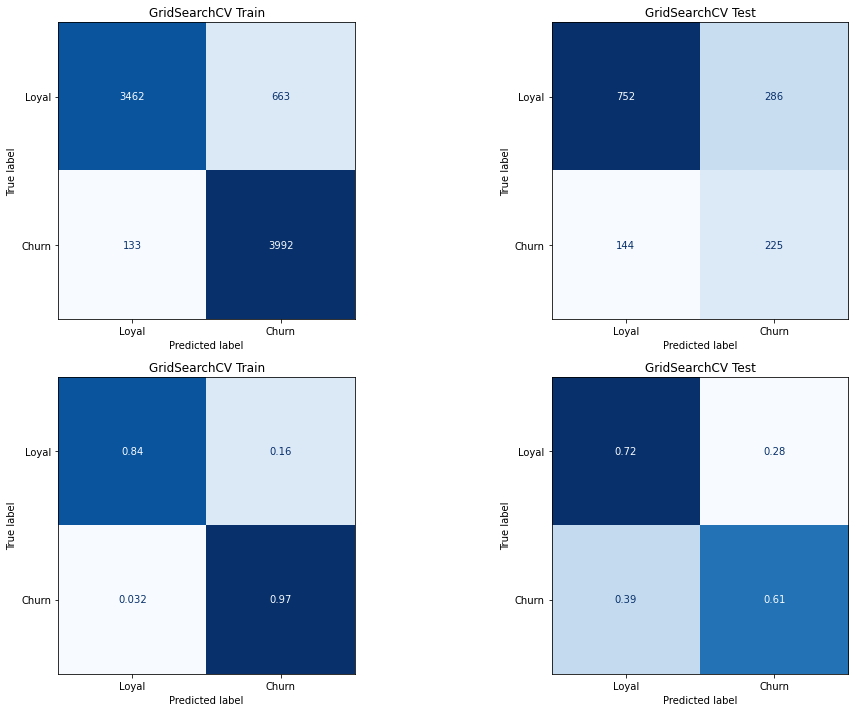

knn
knn


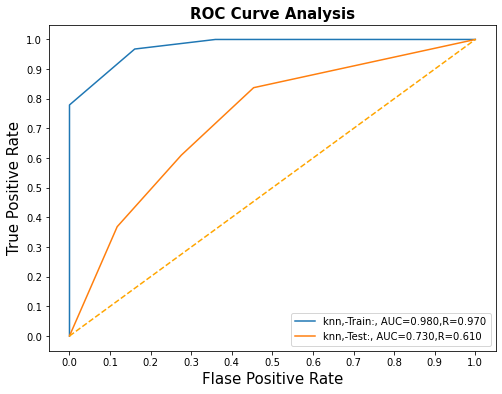

---

dt


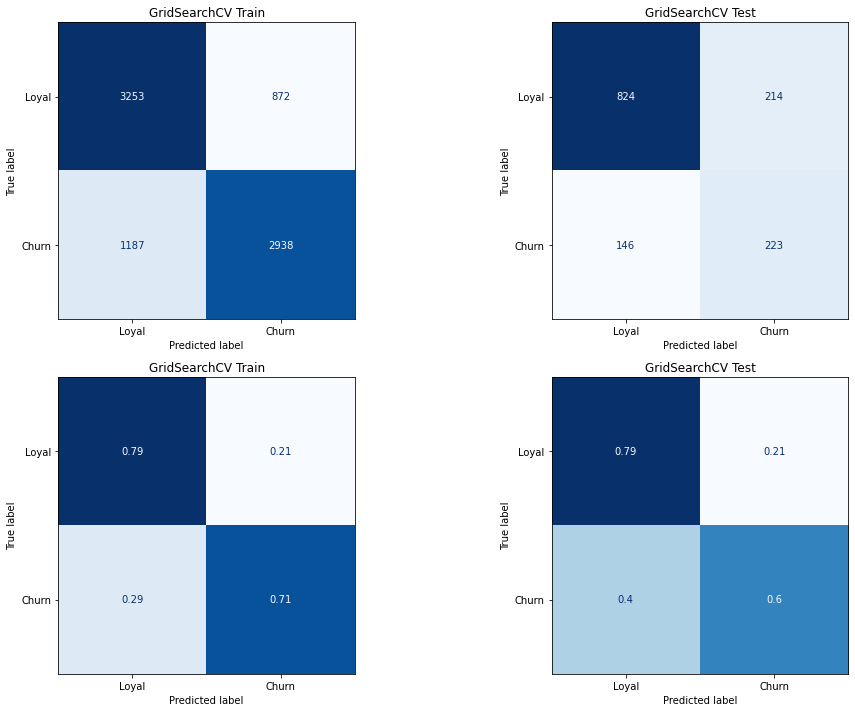

dt
dt


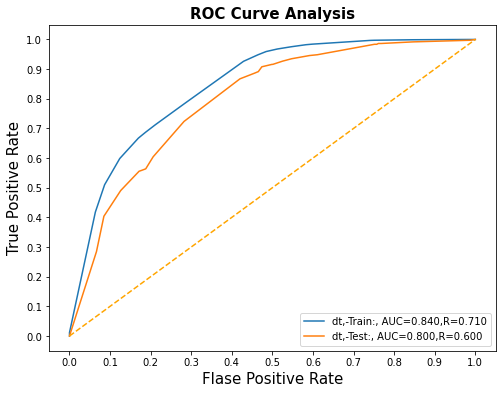

---

rf


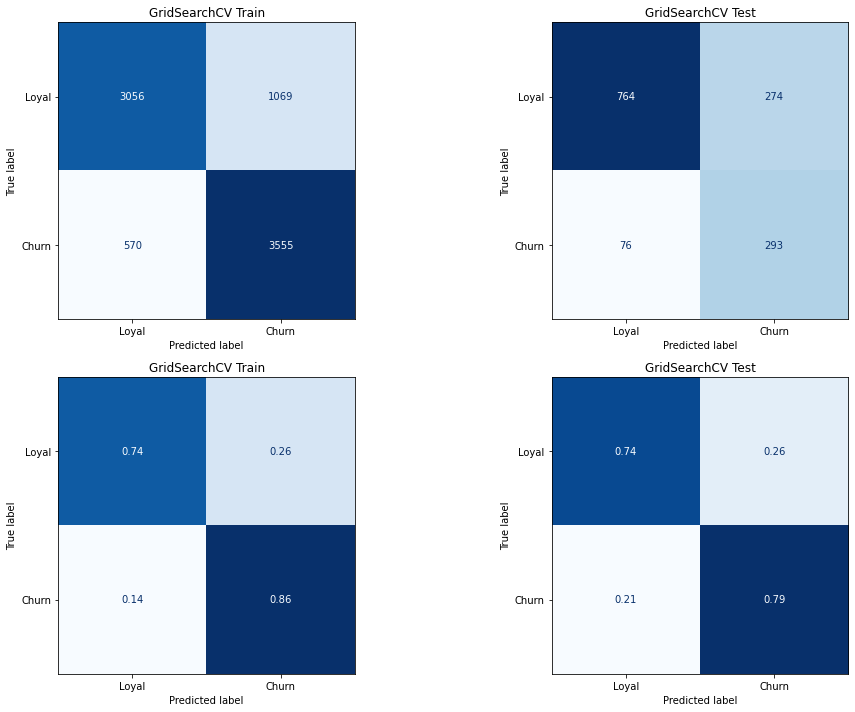

rf
rf


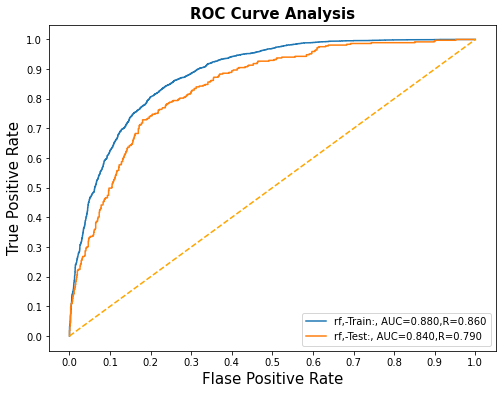

---

In [55]:
# Get Data
X = df_wD.drop(columns=["Churn"])
y = df_wD["Churn"]


# paramScenarios(parmsNumber,dataNumber)
dictOfHyperParams, colsToInclude = paramScenarios(2,2)
classifiers = createDfsOFClassifiers(dictOfHyperParams)

#Create Line Between Printouts
display(Markdown('---'))

X1 = X[colsToInclude]

X_train, y_train, X_test, y_test = get_Scaled_TrainTestSplit_W_orWO_Smote(X1,y,"Y")
display(Markdown('---'))

warnings.filterwarnings("ignore")
df_classifiers_I2 = pd.DataFrame(columns=['clf_name','clf'])
df_classifier_scores = pd.DataFrame(columns=['clf_name','set','mscore'])

for clf_name, classifier in classifiers:
    pipe = classifier
    pipe.fit(X_train, y_train)
    modelscore_Train = round(pipe.score(X_train, y_train),2)
    modelscore_Test = round(pipe.score(X_test, y_test),2)
    
    # Store classifiers and scoring into a dataframe for future use
    df_classifiers_I2 = df_classifiers_I2.append({'clf_name':clf_name, 'clf':classifier,"X_test":X_test,"y_test":y_test}, ignore_index=True)
    df_classifier_scores = df_classifier_scores.append({'clf_name':clf_name, "set":"Train","mscore":modelscore_Train}, ignore_index=True)
    df_classifier_scores = df_classifier_scores.append({'clf_name':clf_name, "set":"Test","mscore":modelscore_Test}, ignore_index=True)

df_All_classifierData_I2 , df_All_classifierData_Test_I2, df_All_classifierScores_Test_I2 = createvisuals(df_classifiers_I2,X_train,y_train,X_test,y_test, df_classifier_scores)

### Review Train vs. Test Accuracy Scores For Overfitting <a class="anchor" id="i2overfit"></a>

In [56]:
df_All_classifierData_I2["Rnd"] = 2
df_All_classifierData_I2[["Rnd","clf_name","set","mscore","recall","precision"]]

,Rnd,clf_name,set,mscore,recall,precision
0,2,knn,Train,0.97,0.97,0.86
1,2,knn,Test,0.61,0.61,0.44
2,2,dt,Train,0.71,0.71,0.77
3,2,dt,Test,0.60,0.60,0.51
4,2,rf,Train,0.86,0.86,0.77
5,2,rf,Test,0.79,0.79,0.52


### Veiw Test results only <a class="anchor" id="i2scores"></a>

  clf_name dataset   auc  recall  precision  mscore modifiers
5       rf    Test  0.84    0.79       0.52    0.79      None
1      knn    Test  0.73    0.61       0.44    0.61      None
3       dt    Test  0.80    0.60       0.51    0.60      None



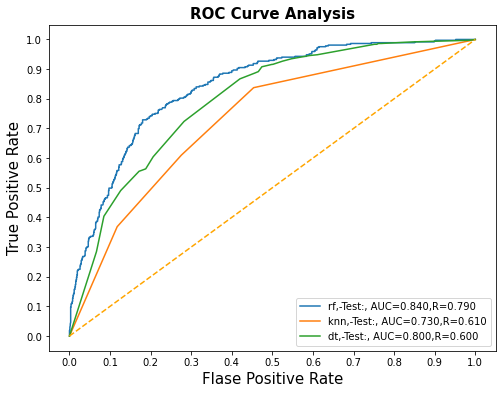

In [57]:
#sort both dataframes by recall for presentation
# View Scores
df_All_classifierScores_Test_I2 = df_All_classifierScores_Test_I2.sort_values(by="recall", ascending=False)
print(df_All_classifierScores_Test_I2)

#View ROC
df_All_classifierData_Test_I2 = df_All_classifierData_Test_I2.sort_values(by="recall", ascending=False)
df_All_classifierData_Test_I2 = df_All_classifierData_Test_I2.reset_index(drop=True)
print()
createROCCurve(df_All_classifierData_Test_I2)

### Review Train vs. Test Accuracy Scores For Overfitting, Side By Side with Round 1

In [58]:
df_Rnd1 = df_All_classifierData_I1[["Rnd","clf_name","set","mscore","recall","precision"]]
# df_Rnd1["Rnd"] = 1
df_Rnd2 = df_All_classifierData_I2[["Rnd","clf_name","set","mscore","recall","precision"]]

df_Rnd_12 = df_Rnd1.merge(df_Rnd2,on=["clf_name","set"])
df_Rnd_12

,Rnd_x,clf_name,set,mscore_x,recall_x,precision_x,Rnd_y,mscore_y,recall_y,precision_y
0,1,knn,Train,0.71,0.71,0.77,2,0.97,0.97,0.86
1,1,knn,Test,0.54,0.54,0.55,2,0.61,0.61,0.44
2,1,dt,Train,0.41,0.41,0.67,2,0.71,0.71,0.77
3,1,dt,Test,0.39,0.39,0.68,2,0.60,0.60,0.51
4,1,rf,Train,0.43,0.43,0.71,2,0.86,0.86,0.77
5,1,rf,Test,0.39,0.39,0.67,2,0.79,0.79,0.52


OBSERVATIONS:  
* `After SMOTE and narrowing parametets, getting better scores than previous round of models  (still without tuning), Recall Scores Range from 61-80`
* `However, overfitting for all models still a big issue`

Observations:

### Save all Iteration 2 Data

In [59]:
with open('./data/df_classifiers_I2.pickle', 'wb') as f:
    pickle.dump(df_classifiers_I2, f)

with open('./data/df_All_classifierData_I2.pickle', 'wb') as f:
    pickle.dump(df_All_classifierData_I2, f)
    
with open('./data/df_All_classifierScores_Test_I2.pickle', 'wb') as f:
    pickle.dump(df_All_classifierScores_Test_I2, f)

## Iteration 3

### Create/ Fit Classifiers using Pipeline/ Create Visuals <a class="anchor" id="(#I3Model"></a>

---

SMOTED
: 1    4125
0    4125
Name: Churn, dtype: int64


---

knn


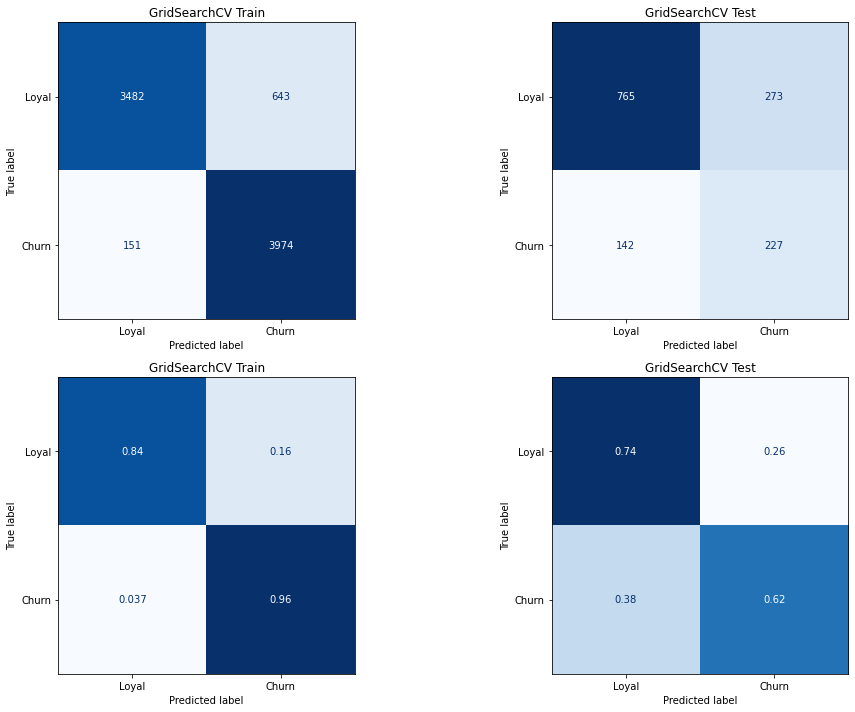

knn
knn


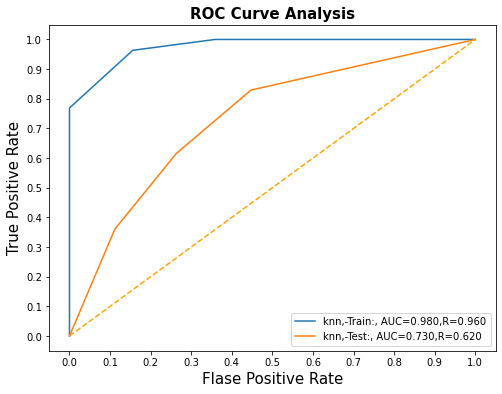

---

dt


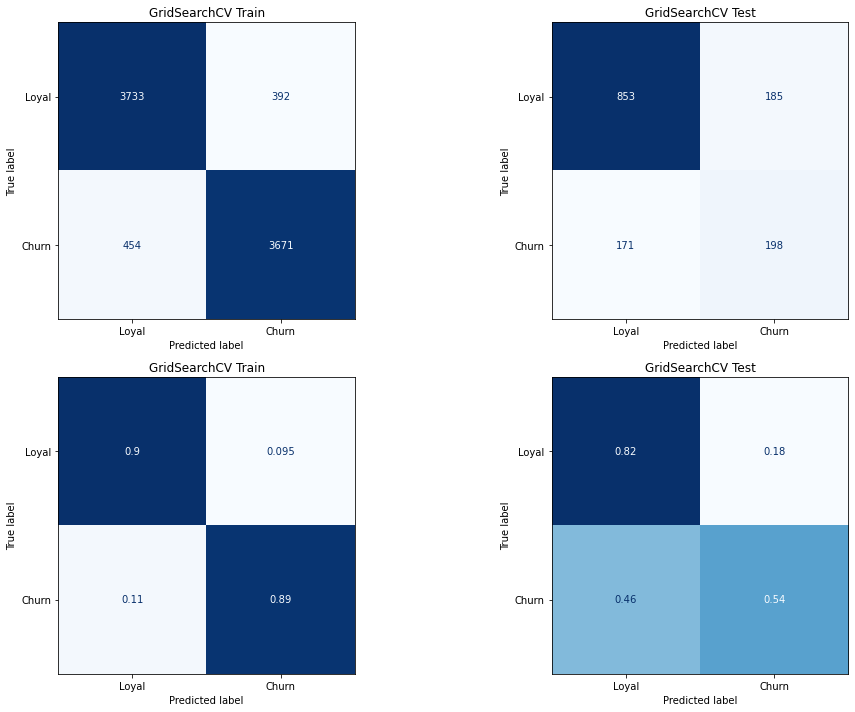

dt
dt


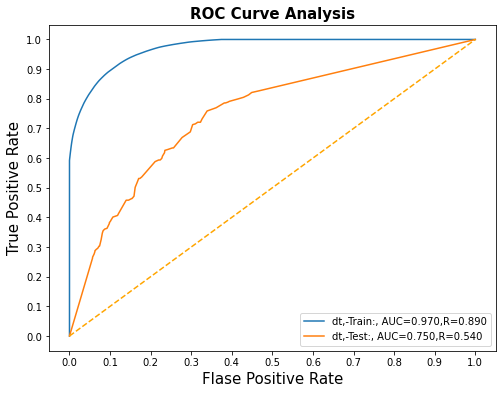

---

rf


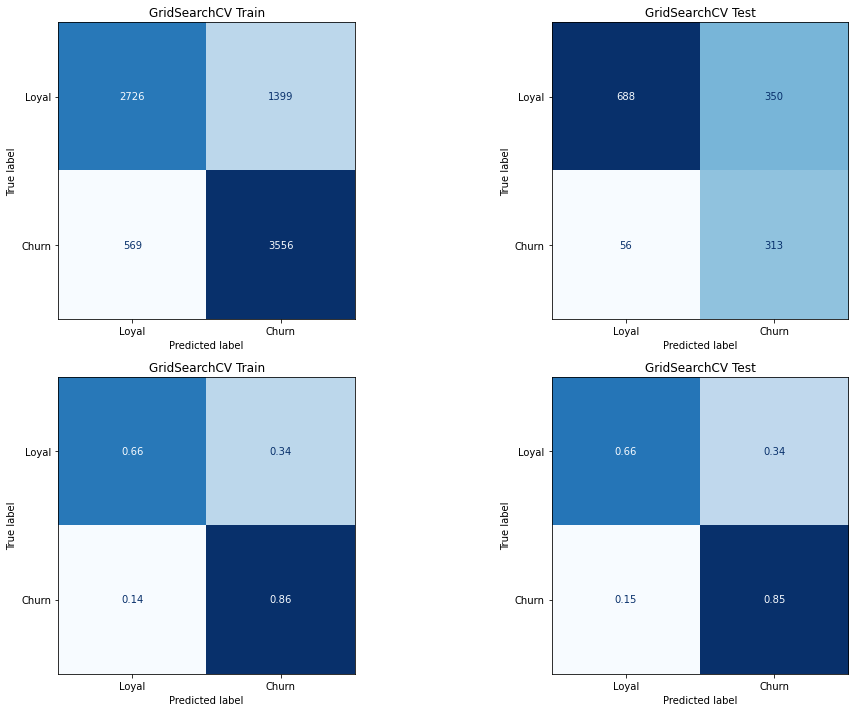

rf
rf


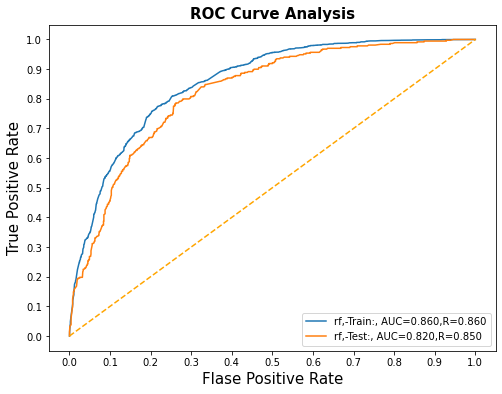

---

In [60]:
# Get Data
X = df_wD.drop(columns=["Churn"])
y = df_wD["Churn"]


# paramScenarios(parmsNumber,dataNumber)
dictOfHyperParams, colsToInclude = paramScenarios(3,3)
classifiers = createDfsOFClassifiers(dictOfHyperParams)

#Create Line Between Printouts
display(Markdown('---'))

X1 = X[colsToInclude]

X_train, y_train, X_test, y_test = get_Scaled_TrainTestSplit_W_orWO_Smote(X1,y,"Y")
display(Markdown('---'))

warnings.filterwarnings("ignore")
df_classifiers_I3 = pd.DataFrame(columns=['clf_name','clf'])
df_classifier_scores = pd.DataFrame(columns=['clf_name','set','mscore'])

for clf_name, classifier in classifiers:
    pipe = classifier
    pipe.fit(X_train, y_train)
    modelscore_Train = round(pipe.score(X_train, y_train),2)
    modelscore_Test = round(pipe.score(X_test, y_test),2)
    
    # Store classifiers and scoring into a dataframe for future use
    df_classifiers_I3 = df_classifiers_I3.append({'clf_name':clf_name, 'clf':classifier,"X_test":X_test,"y_test":y_test}, ignore_index=True)
    df_classifier_scores = df_classifier_scores.append({'clf_name':clf_name, "set":"Train","mscore":modelscore_Train}, ignore_index=True)
    df_classifier_scores = df_classifier_scores.append({'clf_name':clf_name, "set":"Test","mscore":modelscore_Test}, ignore_index=True)

df_All_classifierData_I3 , df_All_classifierData_Test_I3, df_All_classifierScores_Test_I3 = createvisuals(df_classifiers_I3,X_train,y_train,X_test,y_test, df_classifier_scores)

### Review Train vs. Test Accuracy Scores For Overfitting <a class="anchor" id="i3overfit"></a>

In [61]:
df_All_classifierData_I3["Rnd"] = 3
df_All_classifierData_I3[["Rnd","clf_name","set","mscore","recall","precision"]]

,Rnd,clf_name,set,mscore,recall,precision
0,3,knn,Train,0.96,0.96,0.86
1,3,knn,Test,0.62,0.62,0.45
2,3,dt,Train,0.89,0.89,0.90
3,3,dt,Test,0.54,0.54,0.52
4,3,rf,Train,0.86,0.86,0.72
5,3,rf,Test,0.85,0.85,0.47


### Veiw Test results only <a class="anchor" id="i3scores"></a>

  clf_name dataset   auc  recall  precision  mscore modifiers
5       rf    Test  0.82    0.85       0.47    0.85      None
1      knn    Test  0.73    0.62       0.45    0.62      None
3       dt    Test  0.75    0.54       0.52    0.54      None



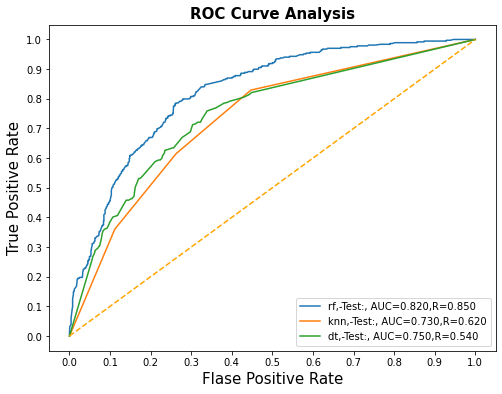

In [62]:
#sort both dataframes by recall for presentation
# View Scores
df_All_classifierScores_Test_I3 = df_All_classifierScores_Test_I3.sort_values(by="recall", ascending=False)
print(df_All_classifierScores_Test_I3)

#View ROC
df_All_classifierData_Test_I3 = df_All_classifierData_Test_I3.sort_values(by="recall", ascending=False)
df_All_classifierData_Test_I3 = df_All_classifierData_Test_I3.reset_index(drop=True)
print()
createROCCurve(df_All_classifierData_Test_I3)

### Review Train vs. Test Accuracy Scores For Overfitting, Side By Side with Round 1&2

In [63]:
df_Rnd3 = df_All_classifierData_I3[["Rnd","clf_name","set","mscore","recall","precision"]]

df_Rnd_123 = df_Rnd1.merge(df_Rnd2,on=["clf_name","set"]).merge(df_Rnd3,on=["clf_name","set"])
df_Rnd_123

,Rnd_x,clf_name,set,mscore_x,recall_x,precision_x,Rnd_y,mscore_y,recall_y,precision_y,Rnd,mscore,recall,precision
0,1,knn,Train,0.71,0.71,0.77,2,0.97,0.97,0.86,3,0.96,0.96,0.86
1,1,knn,Test,0.54,0.54,0.55,2,0.61,0.61,0.44,3,0.62,0.62,0.45
2,1,dt,Train,0.41,0.41,0.67,2,0.71,0.71,0.77,3,0.89,0.89,0.90
3,1,dt,Test,0.39,0.39,0.68,2,0.60,0.60,0.51,3,0.54,0.54,0.52
4,1,rf,Train,0.43,0.43,0.71,2,0.86,0.86,0.77,3,0.86,0.86,0.72
5,1,rf,Test,0.39,0.39,0.67,2,0.79,0.79,0.52,3,0.85,0.85,0.47


### Save all Iteration 3 Data

In [64]:
with open('./data/df_classifiers_I3.pickle', 'wb') as f:
    pickle.dump(df_classifiers_I3, f)

with open('./data/df_All_classifierData_I3.pickle', 'wb') as f:
    pickle.dump(df_All_classifierData_I3, f)
    
with open('./data/df_All_classifierScores_Test_I3.pickle', 'wb') as f:
    pickle.dump(df_All_classifierScores_Test_I3, f)

# Final Results & Observations <a class="anchor" id="finalObs"></a>

In [65]:
df_Rnd_123a = df_Rnd_123[df_Rnd_123["clf_name"]=="rf"][["Rnd","clf_name","set","mscore","recall","precision"]]
df_Rnd_123a

,Rnd,clf_name,set,mscore,recall,precision
4,3,rf,Train,0.86,0.86,0.72
5,3,rf,Test,0.85,0.85,0.47


OBSERVATIONS:  
* `Given past results, focused on tuning rf classifier, as you can see acheived a 84% recall score without overfitting.  mscores between train and test within a point  `

## Feature Importance <a class="anchor" id="featureImportance"></a>

In [66]:
#get classifier from dataframe, stored above
clf = df_classifiers_I3.iloc[2]["clf"]
clf_name = df_classifiers_I3.iloc[2]["clf_name"]
xtest = df_classifiers_I3.iloc[2]["X_test"]
ytest = df_classifiers_I3.iloc[2]["y_test"]
print(clf_name)

rf


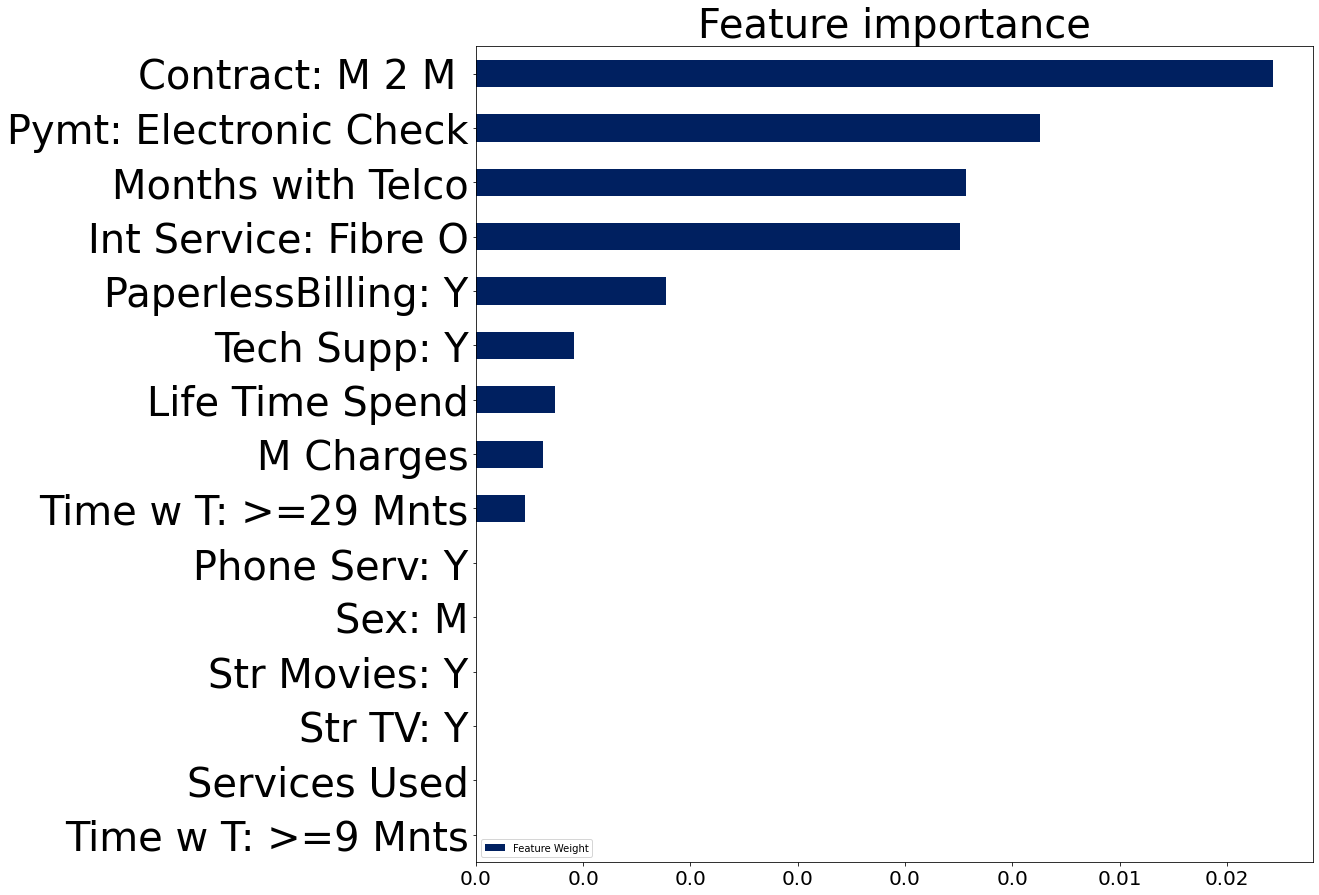

In [67]:
# Get and Print most important features
pipe = clf

# clf.best_estimator_.named_steps['clf'].feature_importances_


feature_importances = pd.concat([pd.DataFrame(xtest.columns, columns = ["features"]),
pd.DataFrame(np.transpose(pipe.best_estimator_.named_steps['clf'].feature_importances_), 
columns = ["coef"])],axis = 1)

feature_importances = feature_importances.merge(df_CleanCol_Names, on="features", how="left")
feature_importances_clean = feature_importances[["Name", "coef"]]
feature_importances_clean.sort_values("coef", ascending = False)
feature_importances_clean_shrt = feature_importances_clean[:15]
feature_importances_clean_shrt = feature_importances_clean_shrt.sort_values("coef", ascending = True)

# import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 15)

ax = feature_importances_clean_shrt.plot(kind = "barh", color='#002060')
plt.title("Feature importance", size=40)
# ax = freq_series.plot(kind='bar')
# ax.set_title('Amount Frequency')
# ax.set_xlabel('Amount ($)')
# ax.set_ylabel('Frequency')
ax.set_yticklabels(feature_importances_clean_shrt['Name'], size=40);
ax.set_xticklabels(round(feature_importances_clean_shrt['coef'],2), size=20);
ax.legend(['Feature Weight'])
plt.show();

## X Factor <a class="anchor" id="Xfactor"></a>
* `Visualizing Recall (TP) vs. Precision (FP) vs. Undetected Tradeoffs (FN)`
* `Also review impact of adjusting Tresholds on recall, precision metrics`

In [68]:
with open('./data/df_classifiers_I3.pickle', 'rb') as f:
    df_classifiers_I3 = pickle.load(f)

with open('./data/df_All_classifierData_I3.pickle', 'rb') as f:
    df_All_classifierData_I3 = pickle.load(f)

In [69]:
#get classifier from dataframe, stored above
clf = df_classifiers_I3.iloc[2]["clf"]
clf_name = df_classifiers_I3.iloc[2]["clf_name"]
print(clf_name)

rf


In [71]:
#get original dataset from train_test split associated with  clf above
df_Classifier_Data_specified = df_All_classifierData_I3[(df_All_classifierData_I3["clf_name1"]==clf_name) & 
                                                        (df_All_classifierData_I3["dataset"]=="Test")]

df_Preds_And_X_test_I3 = df_Classifier_Data_specified.iloc[0]["df"]
X_test_I3= df_Preds_And_X_test_I3.drop(columns=['Loyal_Prob', 'Churn_Prob', 'churn', 'churn_Pred', 'wrong', 'Correct?'])

y_test_I3 = df_Preds_And_X_test_I3["churn"]
y_hat_test_I3 = df_Preds_And_X_test_I3["churn_Pred"]


df_conf_Matrix_O = pd.DataFrame(confusion_matrix(y_test_I3, y_hat_test_I3), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
df_conf_Matrix_ON = pd.DataFrame(confusion_matrix(y_test_I3, y_hat_test_I3,normalize='true'), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])

print("Confusion Matrix with .5  Treshhold\n")
print(df_conf_Matrix_O)
print()
print(df_conf_Matrix_ON)
tn, fp, fn, tp = confusion_matrix(y_test_I3, y_hat_test_I3).ravel()

predictedChurnCnt = tp + fp

recall_test_I3 = round(recall_score(y_test_I3, y_hat_test_I3),2)
precision_test_I3 = round(precision_score(y_test_I3, y_hat_test_I3),2)
accuracy_test_I3 = round(accuracy_score(y_test_I3, y_hat_test_I3),2)

#adjust treshhold to in
y_score_I3 = clf.predict_proba(X_test_I3)[:, 1]

newthreshold = .47
y_hat_test_NewThreshold = adjusted_classes(y_score_I3, newthreshold)

df_conf_Matrix_th = pd.DataFrame(confusion_matrix(y_test_I3, y_hat_test_NewThreshold), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
df_conf_Matrix_thN = pd.DataFrame(confusion_matrix(y_test_I3, y_hat_test_NewThreshold,normalize='true'), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])

display(Markdown('---'))
print(f'Confusion Matrix with {newthreshold} Treshhold\n')
print(df_conf_Matrix_th)
print()
print(df_conf_Matrix_thN)
tn, fp, fn, tp = confusion_matrix(y_test_I3, y_hat_test_NewThreshold).ravel()

recall_test_Th = round(recall_score(y_test_I3, y_hat_test_NewThreshold),2)
precision_test_Th = round(precision_score(y_test_I3, y_hat_test_NewThreshold),2)
accuracy_test_Th = round(accuracy_score(y_test, y_hat_test_NewThreshold),2)

Confusion Matrix with .5  Treshhold

     pred_neg  pred_pos
neg       688       350
pos        56       313

     pred_neg  pred_pos
neg  0.662813  0.337187
pos  0.151762  0.848238


---

Confusion Matrix with 0.47 Treshhold

     pred_neg  pred_pos
neg       589       449
pos        41       328

     pred_neg  pred_pos
neg  0.567437  0.432563
pos  0.111111  0.888889


In [72]:
df_Loyal = df_Preds_And_X_test_I3[df_Preds_And_X_test_I3["churn"]==0][["churn","Churn_Prob"]]
df_churn = df_Preds_And_X_test_I3[df_Preds_And_X_test_I3["churn"]==1][["churn","Churn_Prob"]]

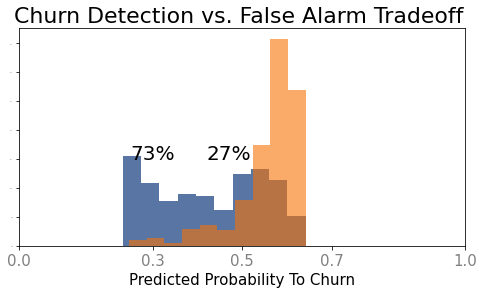

In [73]:
from matplotlib.ticker import PercentFormatter
plt.figure(figsize=(8,4))

ax = plt.gca()
ax.set_facecolor('w')

ax.grid(which='major', axis='y', linestyle='-', color='white', linewidth=0)
ax.grid(which='major', axis='x', linestyle='-', color='white', linewidth=0)

plt.rcParams['axes.facecolor'] = "w"
df_Loyal["Churn_Prob"].hist(bins=10, weights=np.ones_like(df_Loyal["Churn_Prob"]) / len(df_Loyal["Churn_Prob"]),
                            color='#5975A4', alpha=1, linewidth=2)
df_churn["Churn_Prob"].hist(bins=10, weights=np.ones_like(df_churn["Churn_Prob"]) / len(df_churn["Churn_Prob"]),
                            color='xkcd:Orange', alpha=0.6)
# organge #CC8963
#DD8452
# 'xkcd:Orange'
# red, green and blue + the transparency and it returns a color
# plt.xticks([.5], weight = 'bold')
#'xkcd:Orange'

plt.xticks([0,.3,.5,.7,1], size=15, color="grey")
plt.yticks(size=0)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
# plt.legend(("Loyal", "Churn"),fontsize=20)
# ax.get_legend().remove()

ax.text(.25, .15, "73%",fontsize=20)
ax.text(.42 ,.15, "27%",fontsize=20)


# plt.ylabel('Percent Customers')
plt.xlabel('Predicted Probability To Churn', size=15);
plt.title('Churn Detection vs. False Alarm Tradeoff ', size=22)
plt.show();

## Concluding Summary Observations <a class="anchor" id="summaryObs"></a>

### Business Comments

TOP 4 FEATURES PREDICTING CHURN:
<br>

- **1. Type Of Contract -** Month-Month contracts is single most predictive feature, this alings with previous analysis showing 89% of churners are in month-month contracts vs. longer term contracts
- **2. Type of Payment -** Using Electronic Payments is the second my significant feature, this aligns with previous reseach show 66% of churners pay electronically.
- **3. Months with Company -** The thrid most significant feature is Months with Telco.  75% of churn is occurring within 29 months of becoming a Telco customer.
- **4. Type of Internet Service -** The last of the top 4 , but equally as significate is being enrolled in the Fiber Optics program.  66% Churners are using Telcos Fiber Optics

### Modeling Comments

OBSERVATIONS/ FUTURE STEPS:
<br>
- **1. Data Imbalance** Given imbalance, decided to SMOTE(Synthetic Minority Oversampling Technique) to improve classification.

- **2. Selection of Supervised Learning Classifiers**  Initially I tried several different types of classifiers, ranging from Logistic Regression, Naive Bayes, Gradient Boost, Ada, and XGBoost.  Ultimately, I decided to use <b><ins>Knn, Decision Trees and Random Forest</ins></b> , as these classifiers are non-parametric and are highly interpretable.  Interpretability, the disproportionate number of categorical features, along with being able to avoid addressing multicollinearity were the most influential factors in selecting which classifiers to implement for this project.

-   **3. Business Drivers: Churn Detection > False Alarms**  Recommendations on model development were based on secondary research along with working knowledge on the disparity between the cost to acquire vs the cost to retain customers.  In this hypothetical scenario, the CEO of Telco has asked me to place a particular focus on detection at the potential expense of unnecessary outreach activities.
<p>
- **3. Next Steps** Look to develop additional classifiers, ultimately place model into production.